Install Dependencies and Setup


In [ ]:
!pip install opencv-python


In [ ]:
# Import TensorFlow for building and training deep learning models
import tensorflow as tf

# Import os module to interact with the file system (e.g., reading image folders, creating directories)
import os


In [ ]:
# (Optional) Enable dynamic GPU memory allocation to avoid OOM errors
# This is usually already set in Google Colab, but it's safe to include.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Check available GPUs
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


Available GPUs: []


 Remove dodgy images


In [ ]:
import zipfile, os

# Create a folder to hold your data
os.makedirs("data", exist_ok=True)

# Unzip both datasets into 'data' folder
with zipfile.ZipFile("happy.zip", 'r') as zip_ref:
    zip_ref.extractall("data/happy")

with zipfile.ZipFile("sad.zip", 'r') as zip_ref:
    zip_ref.extractall("data/sad")

# Check structure
!ls data


happy  sad


In [ ]:
import os
import cv2
import imghdr

# Path to the main data folder containing subfolders like 'happy' and 'sad'
data_dir = 'data'

# Valid image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Loop through each class folder (e.g., happy, sad)
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)

    # Loop through each image file in the class folder
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try:
            # Try reading the image to confirm it's valid
            img = cv2.imread(image_path)

            # Identify actual image type (e.g., jpeg, png)
            tip = imghdr.what(image_path)

            # If file extension not in valid list, delete it
            if tip not in image_exts:
                print(f"❌ Invalid image type: {image_path}")
                os.remove(image_path)
        except Exception as e:
            print(f"⚠️ Issue with image: {image_path}")
            # Optional: uncomment next line to remove corrupted images
            # os.remove(image_path)


/tmp/ipython-input-2332414623.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


❌ Invalid image type: data/sad/image (24).svg
❌ Invalid image type: data/sad/image (23).svg
❌ Invalid image type: data/sad/image (11).svg
❌ Invalid image type: data/sad/Man with Sad Expression Standing 2 SVG.svg
❌ Invalid image type: data/sad/c640f83c61bca633f60a890611eefffb9f0b2040-2120x1414.jpg.txt
❌ Invalid image type: data/sad/home-office.jpg.txt
❌ Invalid image type: data/sad/image (7).svg
❌ Invalid image type: data/sad/image (18).svg
❌ Invalid image type: data/sad/image (17).svg
❌ Invalid image type: data/sad/moment-of-depression-loneliness-and-emotional-stress-young-b.jpg.txt
❌ Invalid image type: data/sad/depressed-hispanic-girl-with-sad-emotions-and-feelings.jpg.txt
❌ Invalid image type: data/sad/getty_91745128_333755.jpg
❌ Invalid image type: data/sad/upset-woman-sitting-on-couch-alone-at-home.jpg.txt
❌ Invalid image type: data/sad/depositphotos_56411995-stock-illustration-vector-silhouettes.jpg
❌ Invalid image type: data/sad/depression (1).jpg
❌ Invalid image type: data/sad/

Load the data


In [ ]:
# NumPy is used for handling arrays and performing numerical operations
import numpy as np

# Matplotlib's pyplot is used for visualizing images and plotting graphs
from matplotlib import pyplot as plt


In [ ]:
# ---------------------------------------------------------
# Load image dataset from the local 'data' directory
# ---------------------------------------------------------
# 📁 The folder structure should look like this:
# data/
# ├── class1/
# │   ├── img1.jpg
# │   ├── img2.jpg
# ├── class2/
# │   ├── img1.jpg
# │   ├── img2.jpg
#
# Each subfolder name (e.g., class1, class2) is treated as a label.
# TensorFlow will automatically:
# ✅ Read all images from these folders
# ✅ Resize them to a common shape (default: 256x256)
# ✅ Convert them into tensors
# ✅ Assign integer labels based on subfolder names
# ✅ Return a ready-to-train `tf.data.Dataset`

data = tf.keras.utils.image_dataset_from_directory('data')


Found 175 files belonging to 2 classes.


In [ ]:
# ---------------------------------------------------------
# Convert the TensorFlow dataset into a NumPy-style iterator
# ---------------------------------------------------------
# The `image_dataset_from_directory` function returns a tf.data.Dataset
# object, which loads images and labels in batches for training.
#
# `.as_numpy_iterator()` turns this dataset into an iterator that yields
# batches as NumPy arrays — perfect for viewing or debugging the data.
#
# Each iteration gives a tuple: (images, labels)
#   - images → batch of image tensors as NumPy arrays
#   - labels → batch of class labels as NumPy arrays

data_iterator = data.as_numpy_iterator()


In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].shape
#images represented as numpyarrays

(32, 256, 256, 3)

In [ ]:
batch[1]
#lables
#0 -> happy
#1-> sad

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

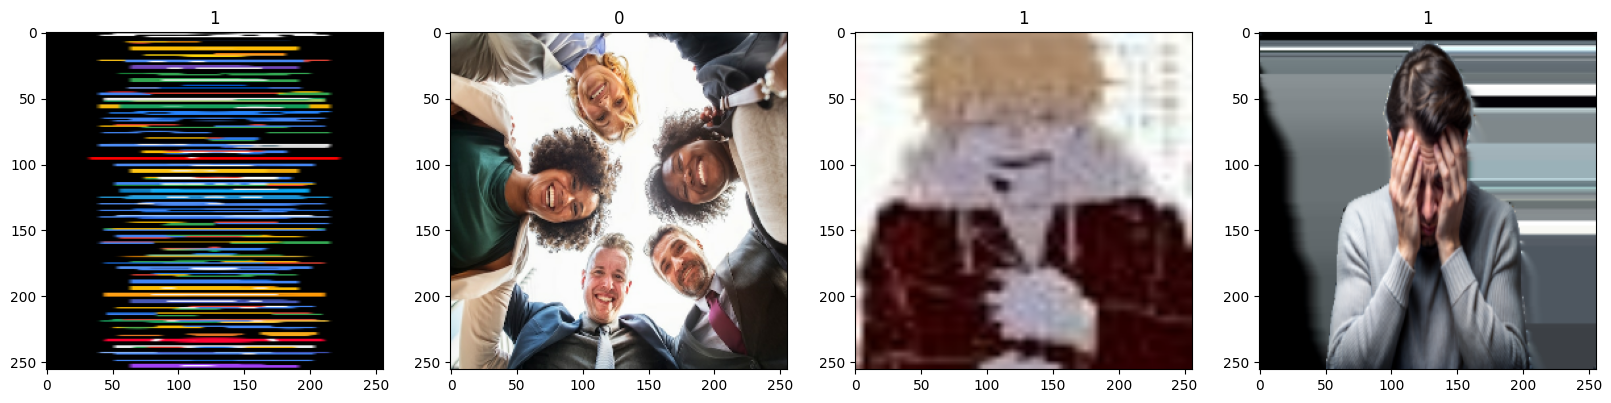

In [ ]:
# ---------------------------------------------------------
# Visualize a few sample images from the dataset
# ---------------------------------------------------------
# Create a figure with 4 columns to display 4 images side by side.
# figsize=(20,20) ensures the images are large and clear.
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Loop through the first 4 images in the current batch
for idx, img in enumerate(batch[0][:4]):
    # Display the image (convert pixel values to int for proper color)
    ax[idx].imshow(img.astype(int))

    # Set the subplot title to show the corresponding label
    ax[idx].title.set_text(batch[1][idx])


***Preprocess*** ***data***


Scale data

In [ ]:
# ---------------------------------------------------------
# Normalize image pixel values for better model performance
# ---------------------------------------------------------
# The dataset contains image tensors (x) and labels (y).
# By default, pixel values are in the range [0, 255].
# Dividing by 255 scales them to [0, 1], which helps:
# ✅ Models converge faster
# ✅ Improves numerical stability
# ✅ Prevents large gradient values
#
# The map() function applies this transformation to
# every (image_batch, label_batch) pair in the dataset.

data = data.map(lambda x, y: (x / 255, y))


In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

In [ ]:
batch[0].max()

np.float32(1.0)

split data

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train_size+val_size+test_size

5

In [ ]:

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

***Deep Model***

Build deep learning model

In [ ]:
# ---------------------------------------------------------
# Import Keras modules for building a Convolutional Neural Network (CNN)
# ---------------------------------------------------------

from tensorflow.keras.models import Sequential
# Sequential allows us to build a model layer by layer in order.
# Ideal for simple CNNs where layers are stacked linearly.

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# Conv2D     -> Convolutional layer for extracting features from images
# MaxPooling2D -> Reduces spatial dimensions of feature maps (downsampling)
# Dense      -> Fully connected layer, used for classification at the end
# Flatten    -> Converts 2D feature maps into 1D vectors for Dense layers
# Dropout    -> Randomly disables neurons during training to prevent overfitting


In [ ]:
model = Sequential()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ---------------------------------------------------------
# Build a CNN for binary image classification (happy vs sad)
# ---------------------------------------------------------
model = Sequential()

# 1️⃣ First convolutional layer + input shape
model.add(Conv2D(16, (3,3), strides=1, activation='relu', input_shape=(256,256,3)))
# - 16 filters of 3x3
# - Stride of 1
# - ReLU activation
# - Input shape 256x256 RGB images

# 2️⃣ Max pooling layer
model.add(MaxPooling2D())
# - Reduces spatial dimensions (downsampling)

# 3️⃣ Second convolutional layer
model.add(Conv2D(32, (3,3), strides=1, activation='relu'))
# - 32 filters for more complex features

# 4️⃣ Max pooling
model.add(MaxPooling2D())

# 5️⃣ Third convolutional layer
model.add(Conv2D(16, (3,3), strides=1, activation='relu'))

# 6️⃣ Max pooling
model.add(MaxPooling2D())

# 7️⃣ Flatten layer
model.add(Flatten())
# - Converts 2D feature maps to 1D vector

# 8️⃣ Fully connected layer
model.add(Dense(256, activation='relu'))
# - 256 neurons, ReLU activation

# 9️⃣ Output layer
model.add(Dense(1, activation='sigmoid'))
# - 1 neuron for binary classification
# - Sigmoid activation outputs probability of class


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)


**7. Train**

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5802 - loss: 1.2454 - val_accuracy: 0.4688 - val_loss: 1.1842
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5448 - loss: 0.9398 - val_accuracy: 0.5625 - val_loss: 0.6872
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5573 - loss: 0.6824 - val_accuracy: 0.7500 - val_loss: 0.6299
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5208 - loss: 0.6568 - val_accuracy: 0.6875 - val_loss: 0.6149
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7271 - loss: 0.5918 - val_accuracy: 0.7500 - val_loss: 0.5306
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7896 - loss: 0.5361 - val_accuracy: 0.8750 - val_loss: 0.3536
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8073 - loss: 0.4149 - val_accuracy: 0.8750 - val_loss: 0.2577
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8344 - loss: 0.3405 - val_accuracy: 0.8125 - val_loss: 0.3596
Epoch 9/20
4

**8. Plot Performance**

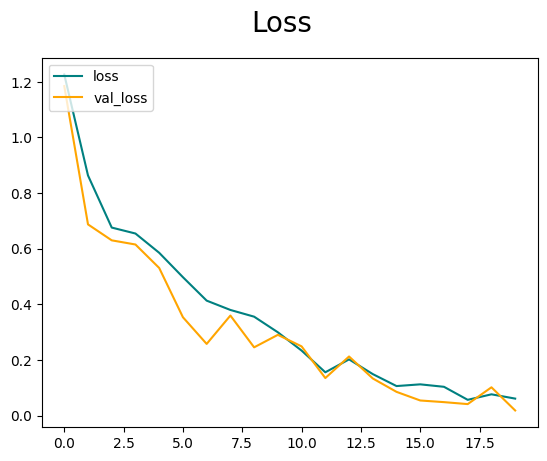

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

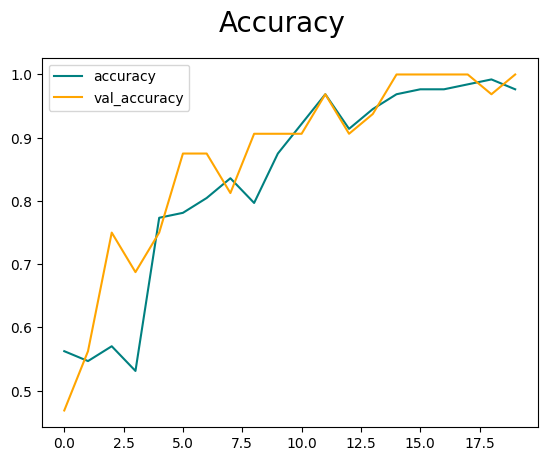

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**9. Evaluate**

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


**10. Test**

In [ ]:
import cv2

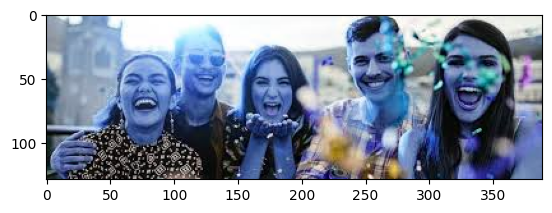

In [ ]:
img = cv2.imread('/content/data/happy/image (12).jpeg')
plt.imshow(img)
plt.show()

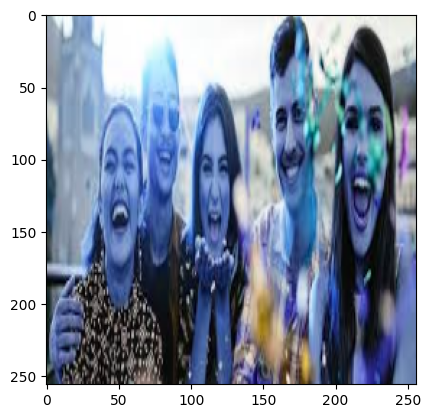

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


In [ ]:
yhat

array([[0.01234984]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


**11. Save the Model**

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('models/imageclassifier.h5')


In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


array([[0.01234984]], dtype=float32)